In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

import pylab
import csv
import datetime
import math
import re
import time
import random
import os

from pandas.tseries.offsets import *
from operator import *

from sklearn.cross_validation import train_test_split

%matplotlib inline

# plt.style.use('ggplot') # Good looking plots
'''
np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 100)
pd.set_option('expand_frame_repr', False)
pd.set_option('precision', 6)
'''
start_time = time.time()

In [20]:
# Thanks to Chenglong Chen for providing this in the forum
def ToWeight(y):   #** faithe** y is a numpy array
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

## Setting seed

In [21]:
seed = 42

## Reading sales data

In [22]:
nrows = None

df_train = pd.read_csv(r'.\data\train.csv', 
                       nrows=nrows,
                       parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

nrows = nrows

df_submit = pd.read_csv(r'.\data\test.csv', 
                        nrows=nrows,
                        parse_dates=['Date'],
                        date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

D:\Users\lenovo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
### Setting a variable to easily distinguish train (1) from submit (0) set
df_train['Set'] = 1
df_submit['Set'] = 0
### Combine train and test set
frames = [df_train, df_submit]
df = pd.concat(frames)

In [25]:
df.head()

Customers       Date  DayOfWeek  Id  Open  Promo    Sales  SchoolHoliday  Set StateHoliday  Store
0      555.0 2015-07-31          5 NaN   1.0      1   5263.0              1    1            0      1
1      625.0 2015-07-31          5 NaN   1.0      1   6064.0              1    1            0      2
2      821.0 2015-07-31          5 NaN   1.0      1   8314.0              1    1            0      3
3     1498.0 2015-07-31          5 NaN   1.0      1  13995.0              1    1            0      4
4      559.0 2015-07-31          5 NaN   1.0      1   4822.0              1    1            0      5

In [26]:
features_x = ['Store', 'Date', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday']
features_y = ['SalesLog']

In [27]:
### Remove rows where store is open, but no sales.
df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0))]

In [28]:
df.loc[df['Set'] == 1, 'SalesLog'] = np.log1p(df.loc[df['Set'] == 1]['Sales']) # = np.log(df['Sales'] + 1)

D:\Users\lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\Users\lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [29]:
df['StateHoliday'] = df['StateHoliday'].astype('category').cat.codes

D:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [30]:
var_name = 'Date'

df[var_name + 'Day'] = pd.Index(df[var_name]).day
df[var_name + 'Week'] = pd.Index(df[var_name]).week
df[var_name + 'Month'] = pd.Index(df[var_name]).month
df[var_name + 'Year'] = pd.Index(df[var_name]).year
df[var_name + 'DayOfYear'] = pd.Index(df[var_name]).dayofyear

df[var_name + 'Day'] = df[var_name + 'Day'].fillna(0)
df[var_name + 'Week'] = df[var_name + 'Week'].fillna(0)
df[var_name + 'Month'] = df[var_name + 'Month'].fillna(0)
df[var_name + 'Year'] = df[var_name + 'Year'].fillna(0)
df[var_name + 'DayOfYear'] = df[var_name + 'DayOfYear'].fillna(0)

features_x.remove(var_name)
features_x.append(var_name + 'Day')
features_x.append(var_name + 'Week')
features_x.append(var_name + 'Month')
features_x.append(var_name + 'Year')
features_x.append(var_name + 'DayOfYear')

D:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
D:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

In [38]:
df['DateInt'] = df['Date'].astype(np.int64)

In [35]:
pd.Index(df[var_name])

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               ...
               '2015-08-01', '2015-08-01', '2015-08-01', '2015-08-01', '2015-08-01', '2015-08-01',
               '2015-08-01', '2015-08-01', '2015-08-01', '2015-08-01'],
              dtype='datetime64[ns]', name='Date', length=1058243, freq=None)

## Reading store data

In [39]:
df_store = pd.read_csv('.\data\store.csv', 
                       nrows=nrows)

In [40]:
df_store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval
0      1         c          a               1270.0                        9.0                    2008.0       0              NaN              NaN              NaN
1      2         a          a                570.0                       11.0                    2007.0       1             13.0           2010.0  Jan,Apr,Jul,Oct
2      3         a          a              14130.0                       12.0                    2006.0       1             14.0           2011.0  Jan,Apr,Jul,Oct
3      4         c          c                620.0                        9.0                    2009.0       0              NaN              NaN              NaN
4      5         a          a              29910.0                        4.0                    2015.0       0              NaN              NaN              NaN

In [41]:
### Convert Storetype and Assortment to numerical categories
df_store['StoreType'] = df_store['StoreType'].astype('category').cat.codes
df_store['Assortment'] = df_store['Assortment'].astype('category').cat.codes

In [42]:
### Convert competition open year and month to float
def convertCompetitionOpen(df):
    try:
        date = '{}-{}'.format(int(df['CompetitionOpenSinceYear']), int(df['CompetitionOpenSinceMonth']))
        return pd.to_datetime(date)
    except:
        return np.nan

df_store['CompetitionOpenInt'] = df_store.apply(lambda df: convertCompetitionOpen(df), axis=1).astype(np.int64)

In [43]:
### Convert competition open year and month to float
def convertPromo2(df):
    try:
        date = '{}{}1'.format(int(df['Promo2SinceYear']), int(df['Promo2SinceWeek']))
        return pd.to_datetime(date, format='%Y%W%w')
    except:
        return np.nan

df_store['Promo2SinceFloat'] = df_store.apply(lambda df: convertPromo2(df), axis=1).astype(np.int64)

In [44]:
s = df_store['PromoInterval'].str.split(',').apply(pd.Series, 1)
s.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
df_store = df_store.join(s)

In [45]:
def monthToNum(date):
    return{
            'Jan' : 1,
            'Feb' : 2,
            'Mar' : 3,
            'Apr' : 4,
            'May' : 5,
            'Jun' : 6,
            'Jul' : 7,
            'Aug' : 8,
            'Sept' : 9, 
            'Oct' : 10,
            'Nov' : 11,
            'Dec' : 12
    }[date]

df_store['PromoInterval0'] = df_store['PromoInterval0'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval1'] = df_store['PromoInterval1'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval2'] = df_store['PromoInterval2'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval3'] = df_store['PromoInterval3'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)

In [46]:
del df_store['PromoInterval']

In [47]:
store_features = ['Store', 'StoreType', 'Assortment', 
                  'CompetitionDistance', 'CompetitionOpenInt',
                  'PromoInterval0']

### Features not helping
# PromoInterval1, PromoInterval2, PromoInterval3

features_x = list(set(features_x + store_features))

In [48]:
df = pd.merge(df, df_store[store_features], how='left', on=['Store'])

In [53]:
### Convert every NAN to -1
for feature in features_x:
    df[feature] = df[feature].fillna(-1)

## Manually Check and Correct some Strange Data in Stores

In [56]:
df.head()

Customers       Date  DayOfWeek  Id  Open  Promo    Sales  SchoolHoliday  Set  StateHoliday  Store  SalesLog  DateDay  DateWeek  DateMonth  DateYear  DateDayOfYear              DateInt  StoreType  Assortment  CompetitionDistance   CompetitionOpenInt  PromoInterval0
0      555.0 2015-07-31          5 NaN   1.0      1   5263.0              1    1             1      1  8.568646       31        31          7      2015            212  1438300800000000000          2           0               1270.0  1220227200000000000            -1.0
1      625.0 2015-07-31          5 NaN   1.0      1   6064.0              1    1             1      2  8.710290       31        31          7      2015            212  1438300800000000000          0           0                570.0  1193875200000000000             1.0
2      821.0 2015-07-31          5 NaN   1.0      1   8314.0              1    1             1      3  9.025816       31        31          7      2015            212  1438300800000000000          0           0              14130.0  1164931200000000000             1.0
3     1498.0 2015-07-31          5 NaN   1.0      1  13995.0              1    1             1      4  9.546527       31        31          7      2015            212  1438300800000000000          2           2                620.0  1251763200000000000            -1.0
4      559.0 2015-07-31          5 NaN   1.0      1   4822.0              1    1             1      5  8.481151       31        31          7      2015            212  1438300800000000000          0           0              29910.0  1427846400000000000            -1.0

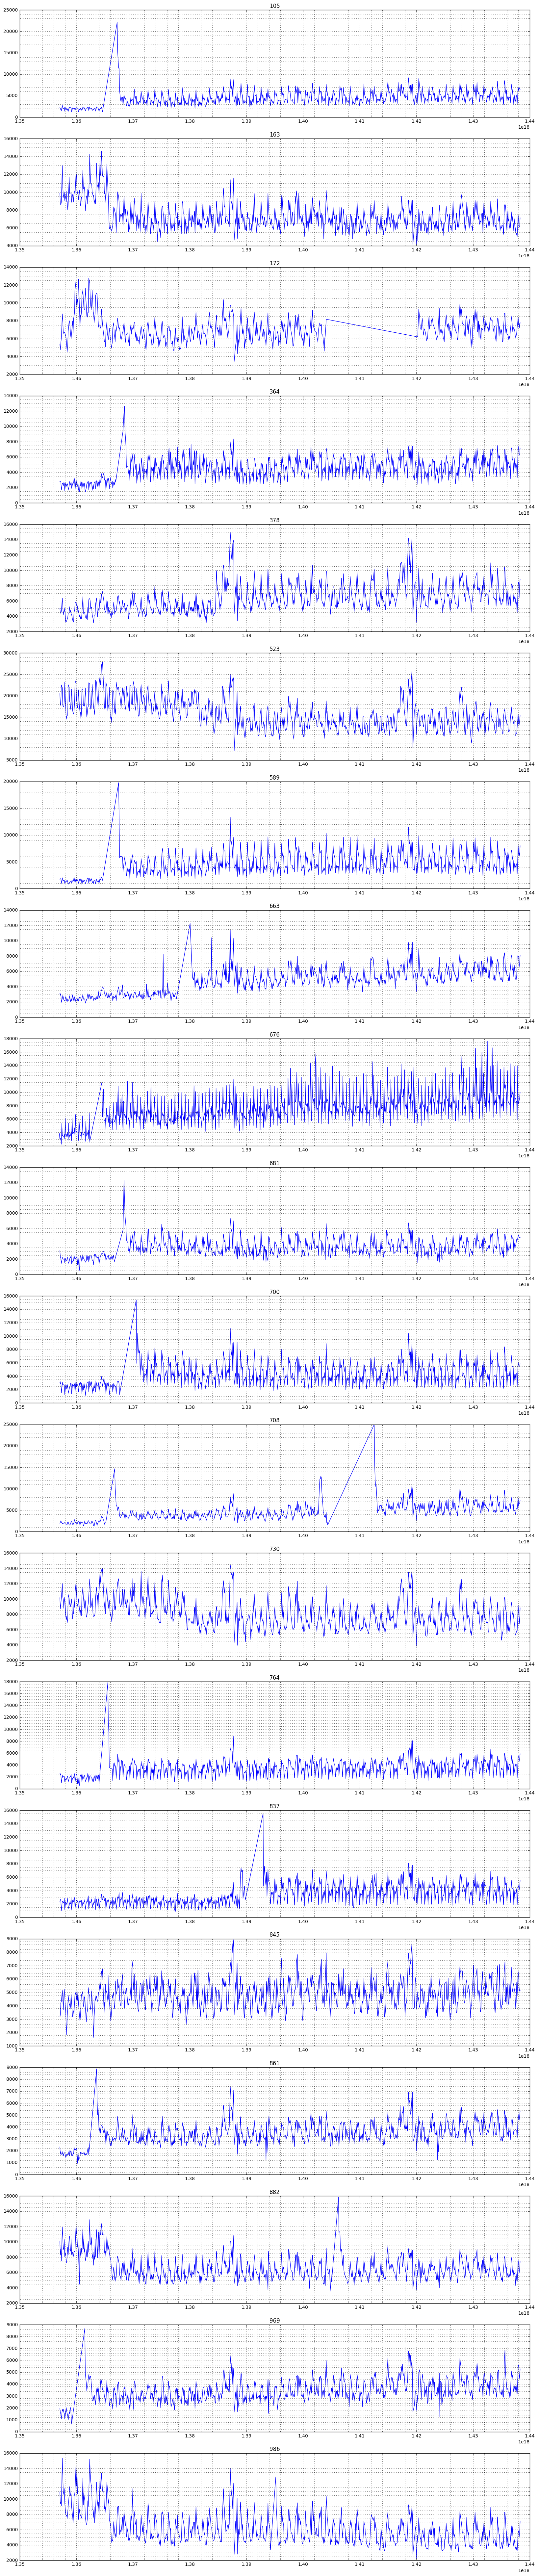

In [55]:
list_stores_to_check = [105,163,172,364,378,523,589,663,676,681,700,708,730,764,837,845,861,882,969,986]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, '-')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

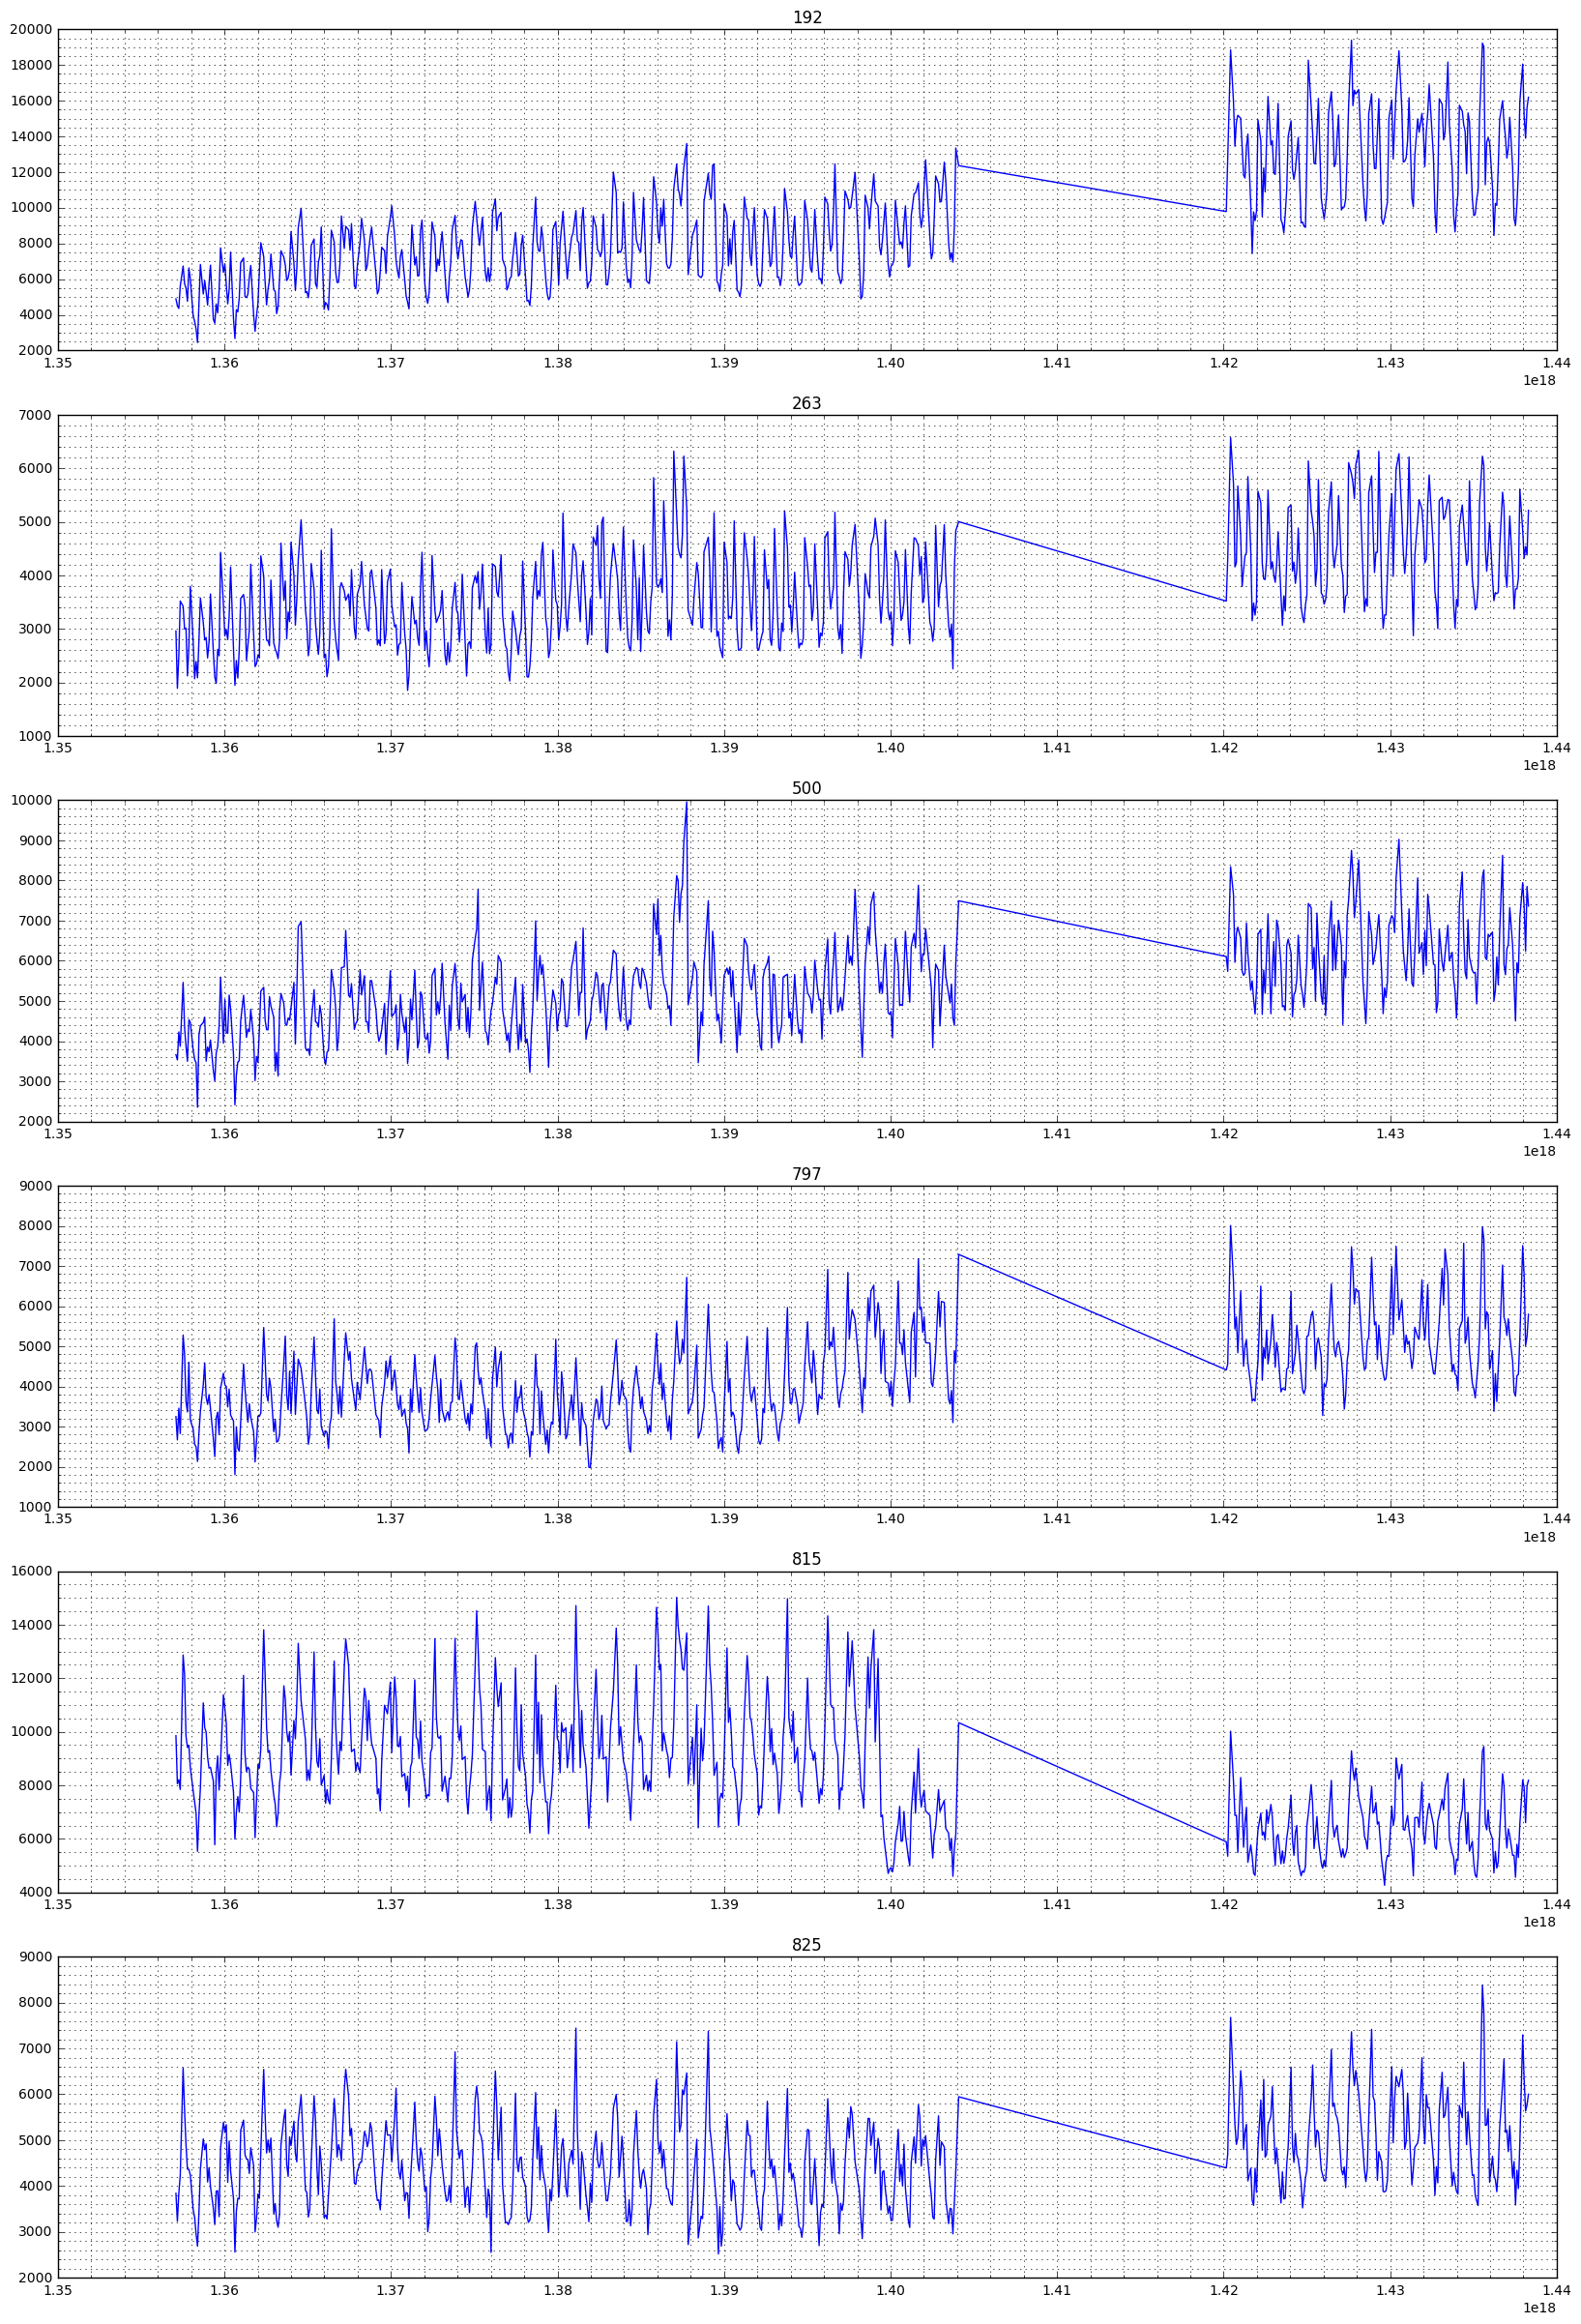

In [58]:
list_stores_to_check = [192,263,500,797,815,825]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, '-')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

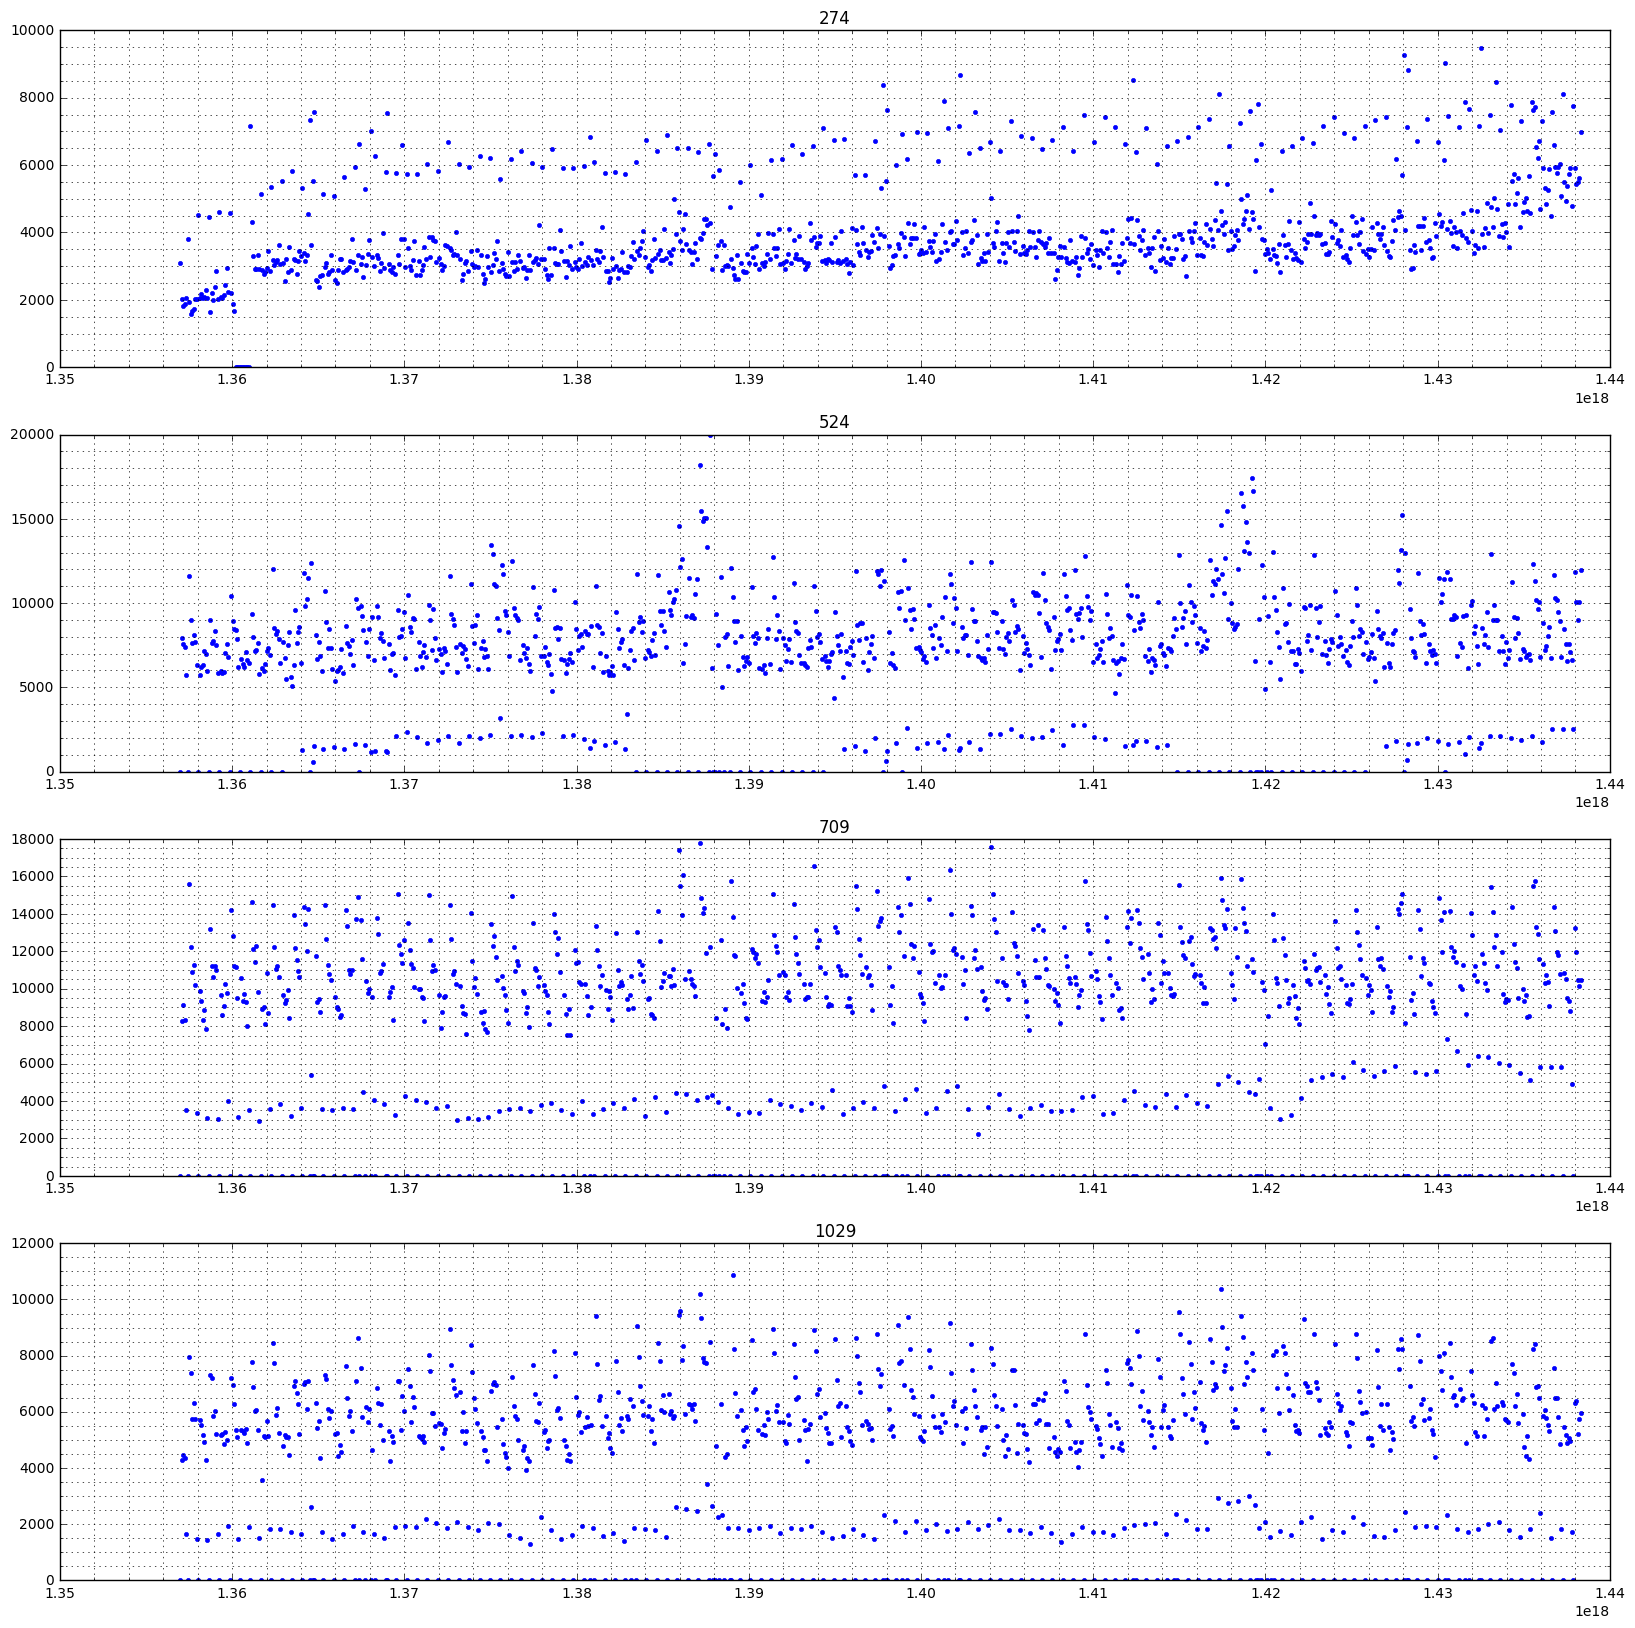

In [59]:
list_stores_to_check = [274,524,709,1029]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, '.')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

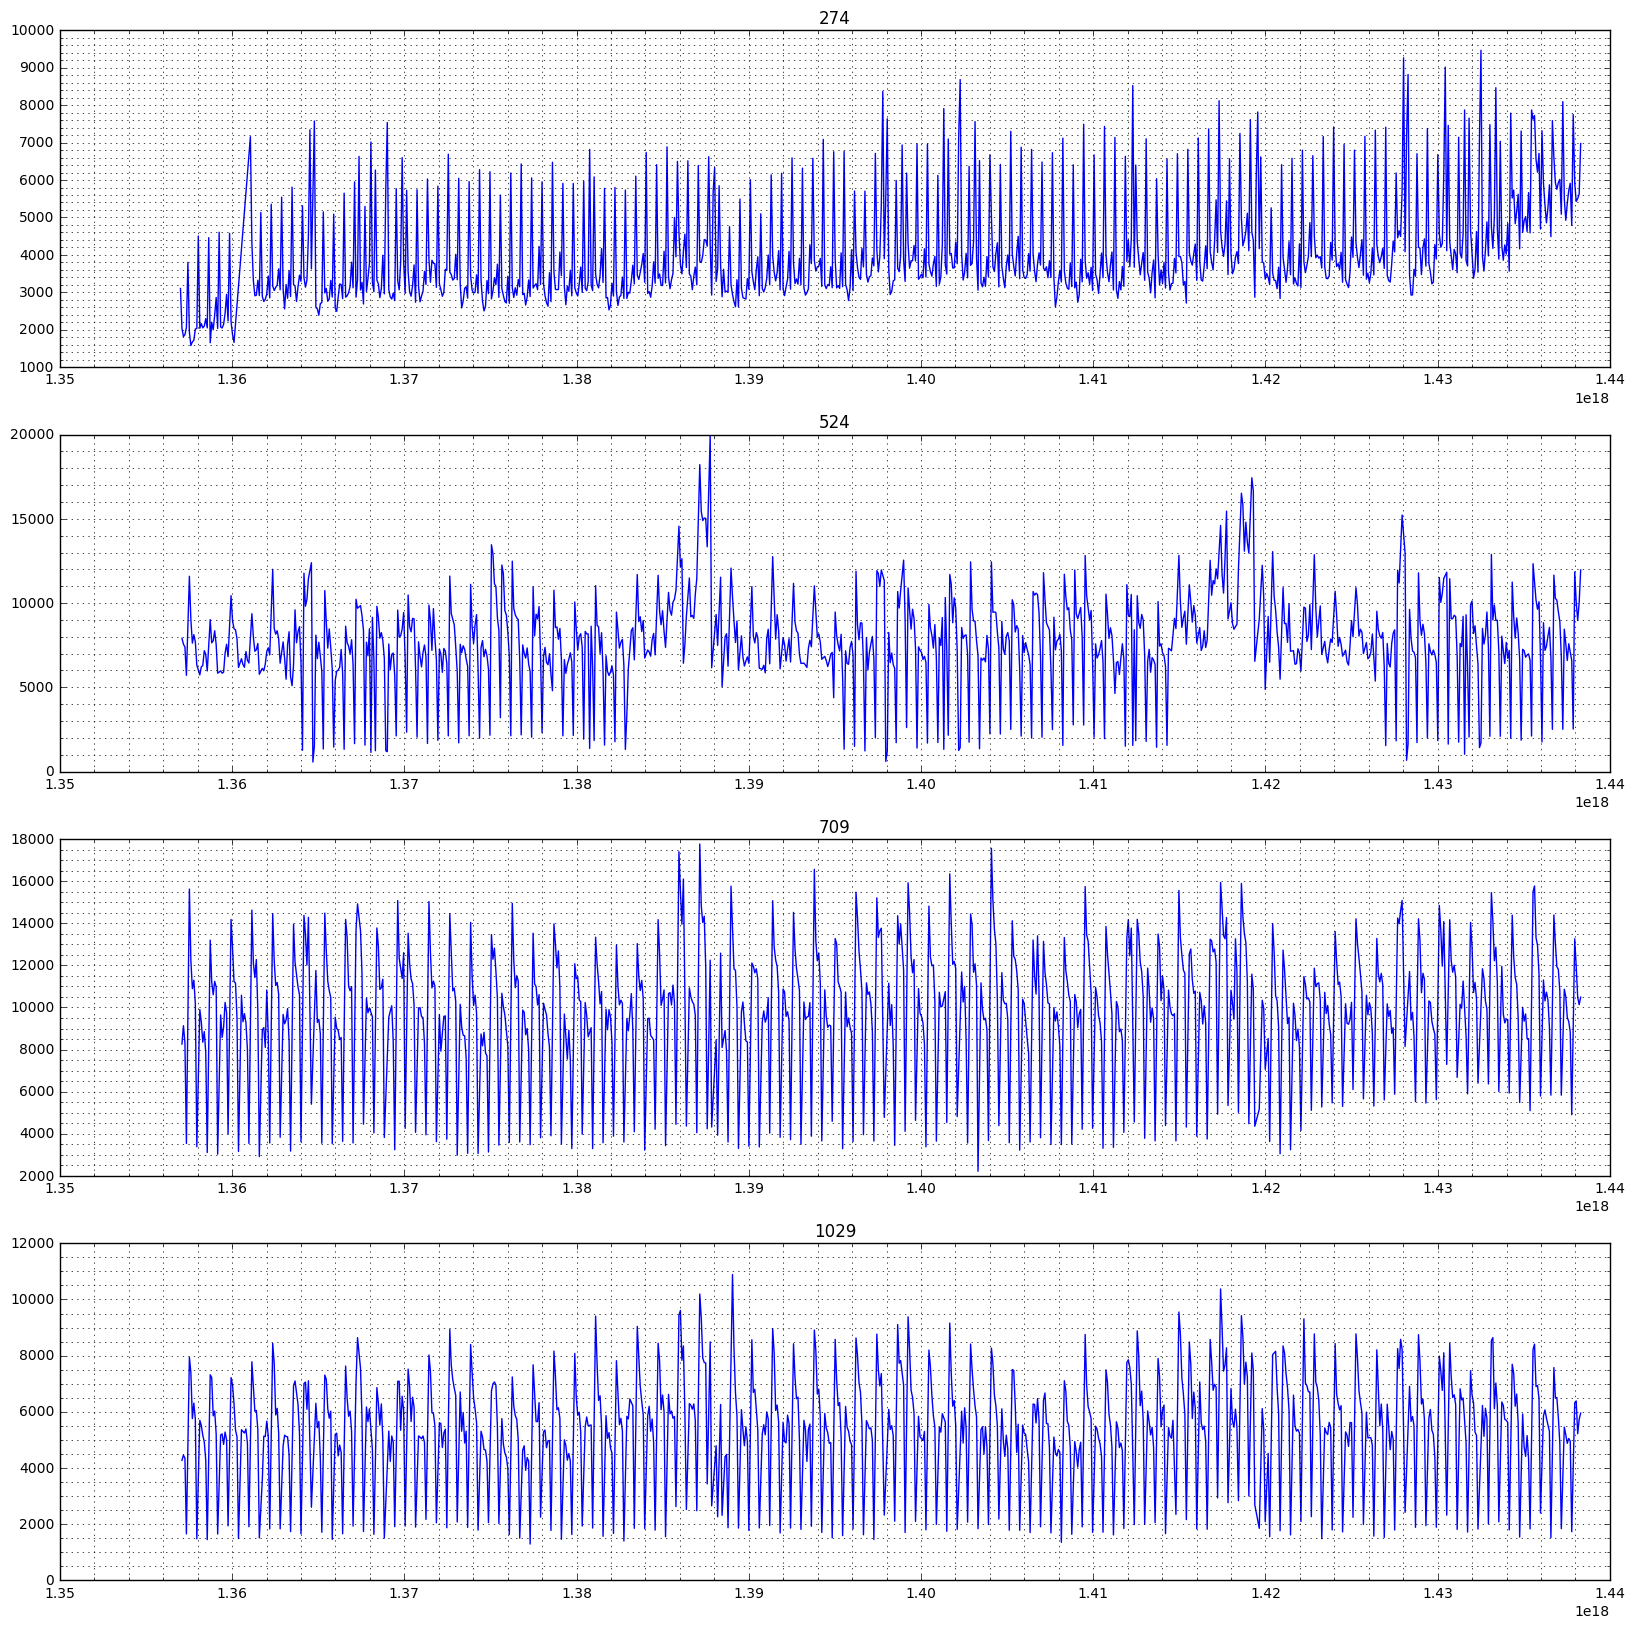

In [60]:
list_stores_to_check = [274,524,709,1029]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, '-')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

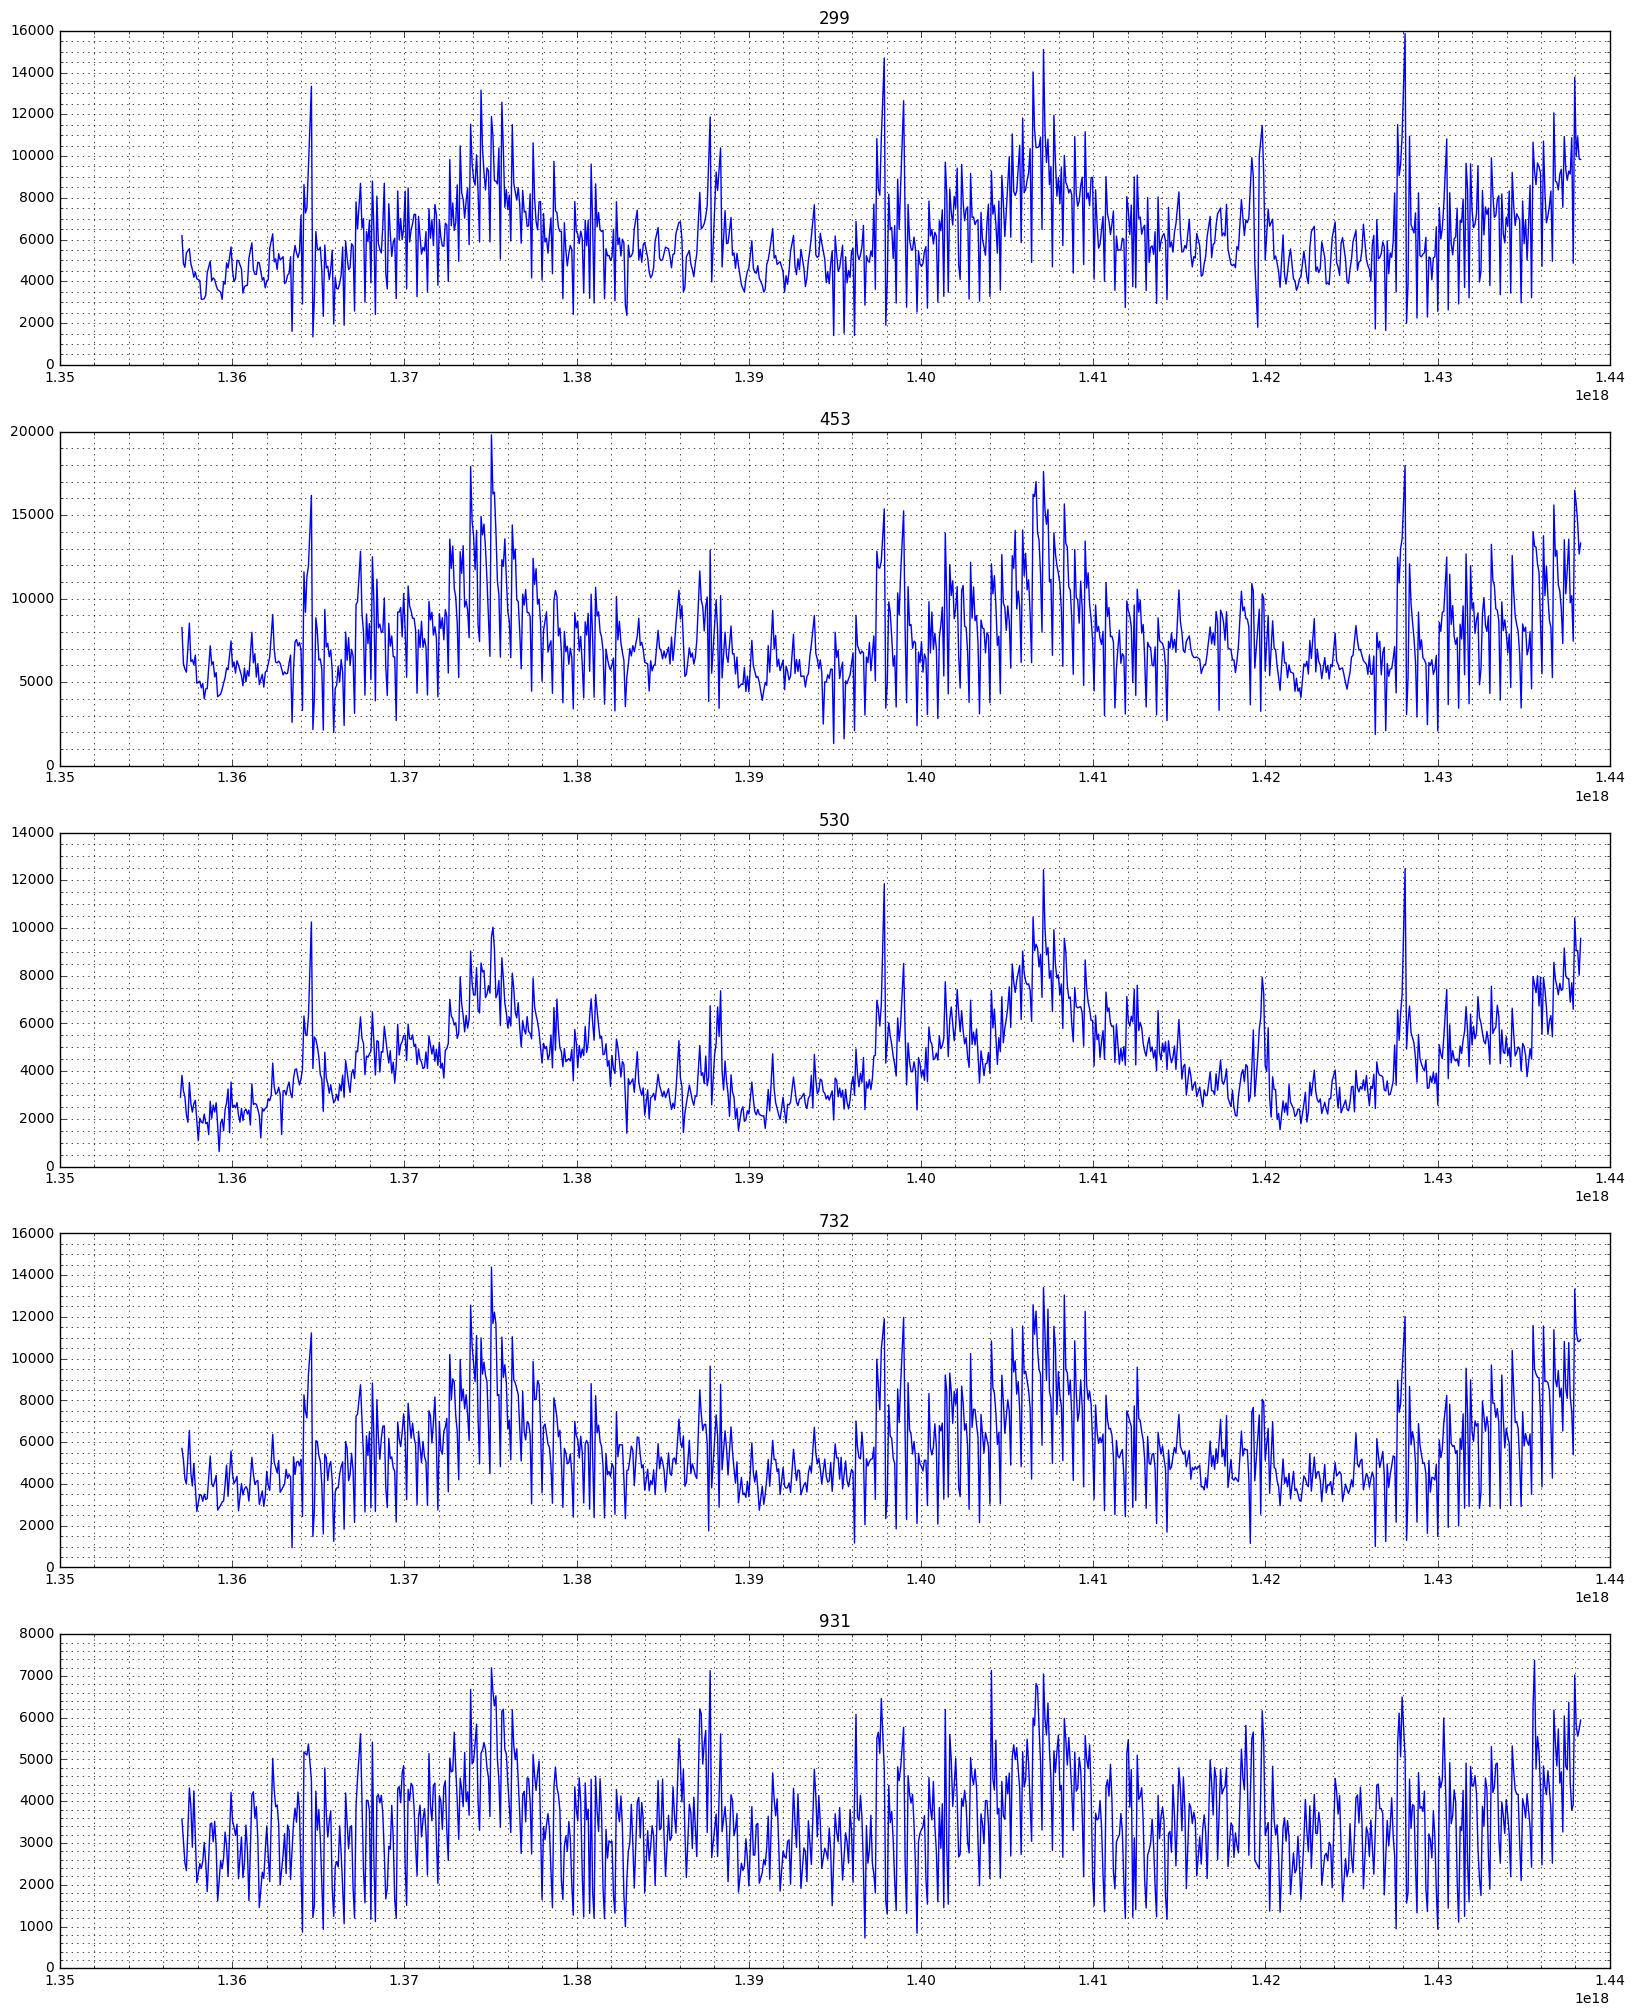

In [61]:
list_stores_to_check = [299,453,530,732,931]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, '-')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

In [66]:
store_dates_to_remove = {   105:1.368e18, 163:1.368e18,
                            172:1.366e18, 364:1.37e18,
                            378:1.39e18, 523:1.39e18,
                            589:1.37e18, 663:1.39e18,
                            676:1.366e18, 681:1.37e18,
                            700:1.373e18, 708:1.368e18,
                            709:1.423e18, 730:1.39e18,
                            764:1.368e18, 837:1.396e18,
                            845:1.368e18, 861:1.368e18,
                            882:1.368e18, 969:1.366e18,
                            986:1.368e18, 192:1.421e18,
                            263:1.421e18, 500:1.421e18,
                            797:1.421e18, 815:1.421e18,
                            825:1.421e18}

for key,value in store_dates_to_remove.items():
    df.loc[(df['Store'] == key) & (df['DateInt'] < value), 'Delete'] = True

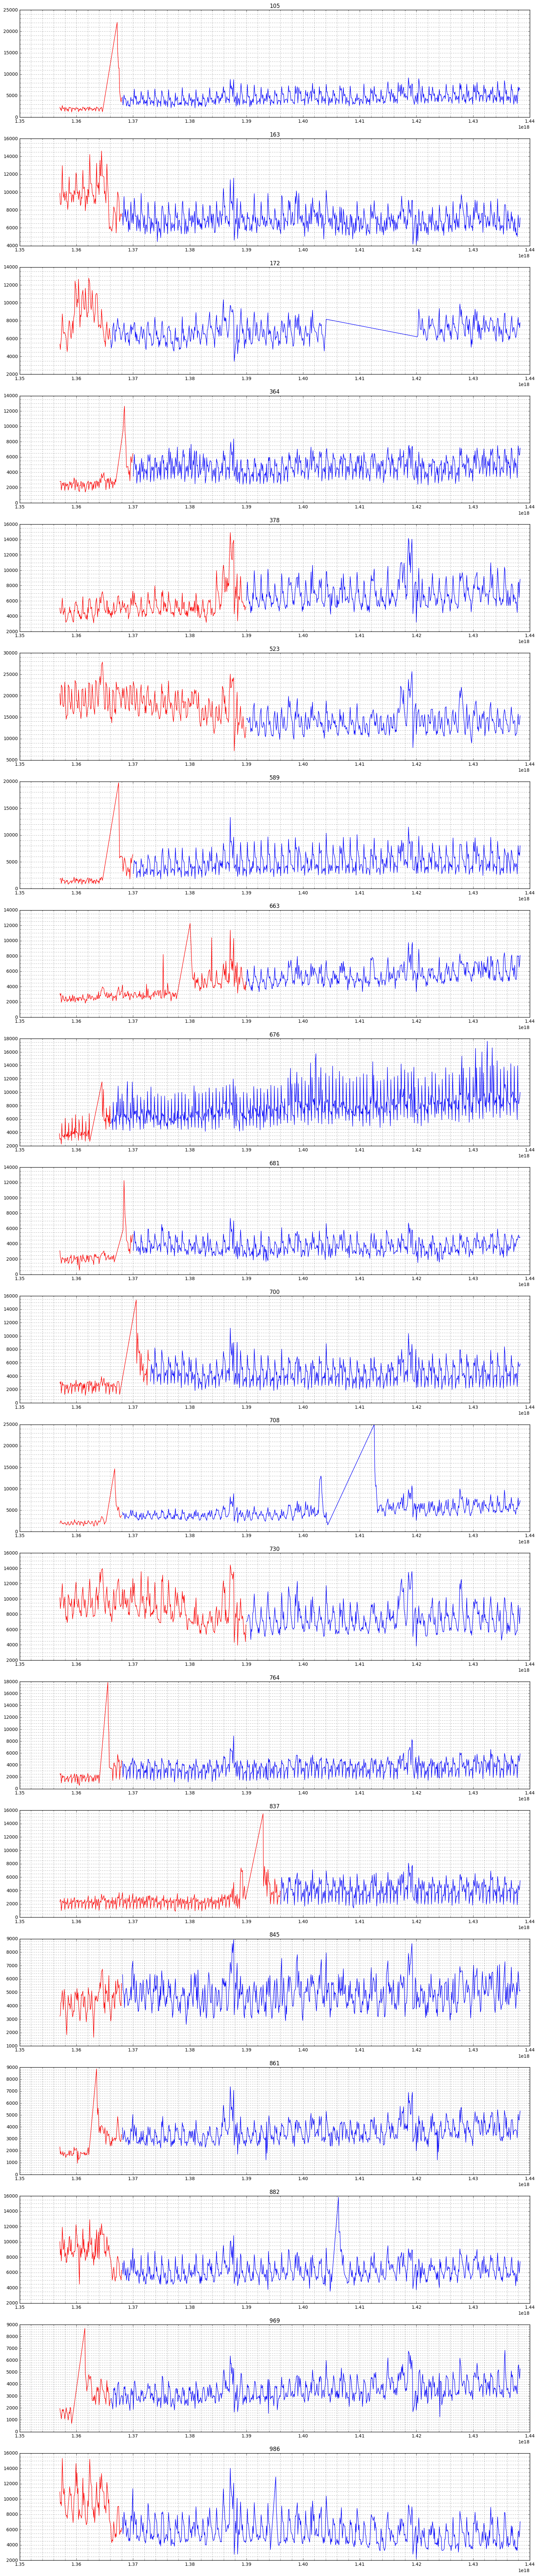

In [67]:
list_stores_to_check = [105,163,172,364,378,523,589,663,676,681,700,708,730,764,837,845,861,882,969,986]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] == True)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] == True)]['Sales']
    
    X2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] != True)]
    y2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] != True)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, 'r-')
    plt.plot(X2['DateInt'], y2, '-')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

In [68]:
### Delete the data where sales in the first period is much different from the rest
df = df.loc[df['Delete'] != True]

## Remove Outliers with Deviation >= 3

In [75]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [84]:
for i in df['Store'].unique():
    df.loc[(df['Set'] == 1) & (df['Store'] == i) & (df['Open'] == 1), 'Outlier'] = \
        mad_based_outlier(df.loc[(df['Set'] == 1) & (df['Store'] == i) & (df['Open'] == 1)]['Sales'], 3)

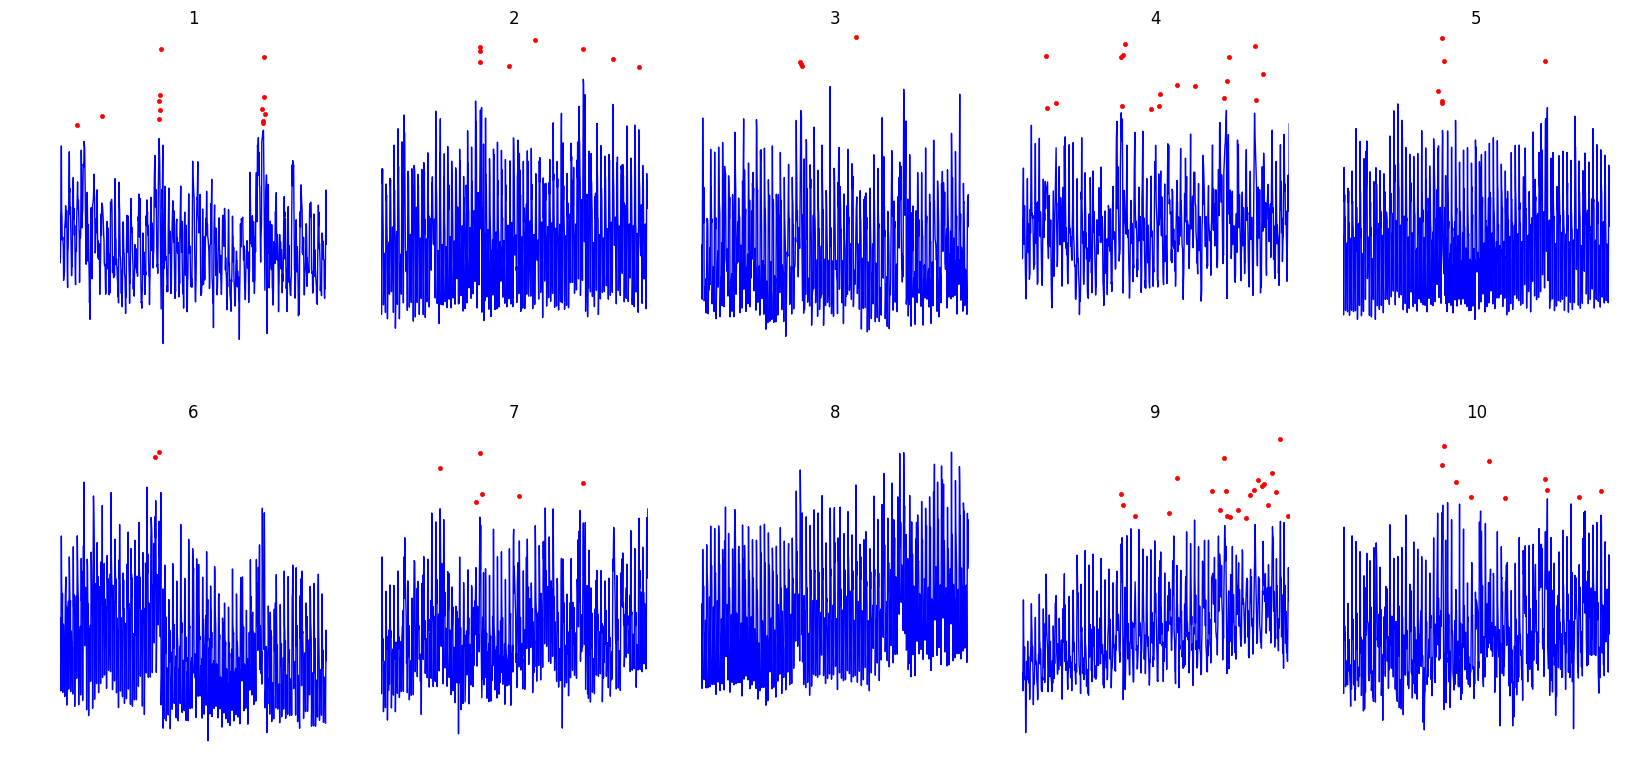

In [85]:
no_stores_to_check = 10

plt.rcParams["figure.figsize"] = [20,no_stores_to_check*5]

for i in range(1,no_stores_to_check+1):
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == False)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == False)]['Sales']

    # Outliers
    X2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == True)]
    y2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == True)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(10,5,i)
    plt.plot(X1['Date'], y1, '-')
    plt.plot(X2['Date'], y2, 'r.')
    plt.title(i)
    plt.axis('off')

## Split Data in Training and Test for Filling in the Outliers

In [87]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_x],
                                                    df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_y],
                                                    test_size=0.1, random_state=seed)

In [88]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [92]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 742560 entries, 642979 to 150763
Data columns (total 16 columns):
DayOfWeek              742560 non-null int64
StateHoliday           742560 non-null int8
DateDayOfYear          742560 non-null int32
PromoInterval0         742560 non-null float64
DateDay                742560 non-null int32
DateWeek               742560 non-null int32
Open                   742560 non-null float64
Store                  742560 non-null int64
SchoolHoliday          742560 non-null int64
DateMonth              742560 non-null int32
Assortment             742560 non-null int8
DateYear               742560 non-null int32
Promo                  742560 non-null int64
CompetitionDistance    742560 non-null float64
CompetitionOpenInt     742560 non-null int64
StoreType              742560 non-null int8
dtypes: float64(3), int32(5), int64(5), int8(3)
memory usage: 67.3 MB


In [93]:
num_round = 200
evallist = [(dtrain, 'train'), (dtest, 'test')]

In [94]:
param = {'bst:max_depth':12,
         'bst:eta':0.01,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1,
         'objective':'reg:linear',
         'nthread':6,
         'seed':seed}

plst = param.items()

bst = xgb.train(plst, dtrain, num_round, evallist, feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)

[0]	train-rmspe:0.996805	test-rmspe:0.996806
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 250 rounds.


In [95]:
features_x

['DayOfWeek',
 'StateHoliday',
 'DateDayOfYear',
 'PromoInterval0',
 'DateDay',
 'DateWeek',
 'Open',
 'Store',
 'SchoolHoliday',
 'DateMonth',
 'Assortment',
 'DateYear',
 'Promo',
 'CompetitionDistance',
 'CompetitionOpenInt',
 'StoreType']

In [ ]:
dpred = xgb.DMatrix(df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True)][features_x])
ypred_bst = bst.predict(dpred)

In [ ]:
df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True), 'SalesLog'] = ypred_bst
df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True), 'Sales'] = np.exp(ypred_bst) - 1